# **AI Virtual Career Counsellor**

In [1]:
# Install required libraries
!pip install scikit-learn pandas matplotlib seaborn tensorflow --quiet

In [2]:
# Import modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import joblib
from sklearn.metrics import accuracy_score, f1_score, hamming_loss, classification_report, ConfusionMatrixDisplay
from tensorflow.keras.models import load_model

In [3]:
# Load data and models
dataset_url = "https://raw.githubusercontent.com/SiddardhaShayini/Career-Recommender-Dataset/refs/heads/main/dataset/cleaned_dataset.csv"
df = pd.read_csv(dataset_url)

In [4]:
df.head()

,Drawing,Dancing,Singing,Sports,Video_Game,Acting,Travelling,Gardening,Animals,Photography,...,Doctor,Pharmisist,Cycling,Knitting,Director,Journalism,Bussiness,Listening_Music,Courses,Career_Options
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,BBA- Bachelor of Business Administration,"Business Analyst, Marketing Executive, HR Mana..."
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,BBA- Bachelor of Business Administration,"Business Analyst, Marketing Executive, HR Mana..."
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,BBA- Bachelor of Business Administration,"Business Analyst, Marketing Executive, HR Mana..."
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,BBA- Bachelor of Business Administration,"Business Analyst, Marketing Executive, HR Mana..."
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,BBA- Bachelor of Business Administration,"Business Analyst, Marketing Executive, HR Mana..."


In [5]:
# Download models
!wget -q https://github.com/SiddardhaShayini/Career-Recommender-Dataset/raw/main/models/best%20%26%20final%20model/career_model.h5
!wget -q https://github.com/SiddardhaShayini/Career-Recommender-Dataset/raw/main/models/best%20%26%20final%20model/career_options_mlb.pkl
!wget -q https://github.com/SiddardhaShayini/Career-Recommender-Dataset/raw/main/models/best%20%26%20final%20model/courses_label_encoder.pkl
!wget -q https://github.com/SiddardhaShayini/Career-Recommender-Dataset/raw/main/models/best%20%26%20final%20model/random_forest_courses_model.pkl


In [8]:
# Preprocessing
X = df.drop(columns=['Courses', 'Career_Options'])
y_courses = df['Courses']

# Safely parse comma-separated career labels
y_career = df['Career_Options'].apply(lambda x: [i.strip() for i in x.split(',')] if isinstance(x, str) else [])


In [11]:
from tensorflow.keras.models import load_model
import joblib

# Load models
rf_model = joblib.load("random_forest_courses_model.pkl")
career_nn_model = load_model("career_model.h5")

# Load encoders with joblib (to avoid UnpicklingError)
course_encoder = joblib.load("courses_label_encoder.pkl")
career_mlb = joblib.load("career_options_mlb.pkl")


In [12]:
# Encode labels
y_courses_encoded = course_encoder.transform(y_courses)
y_career_encoded = career_mlb.transform(y_career)

In [13]:
# Evaluation
from sklearn.model_selection import train_test_split
X_train, X_test, y_course_train, y_course_test, y_career_train, y_career_test = train_test_split(
    X, y_courses_encoded, y_career_encoded, test_size=0.2, random_state=42
)

In [14]:
# Courses (Random Forest)
y_course_pred = rf_model.predict(X_test)
print("=== Random Forest - Courses ===")
print("Accuracy:", accuracy_score(y_course_test, y_course_pred))
print("Macro F1:", f1_score(y_course_test, y_course_pred, average='macro'))

=== Random Forest - Courses ===
Accuracy: 0.9943502824858758
Macro F1: 0.9416033369521741


In [15]:
# Career Options (Neural Network)
y_career_pred = career_nn_model.predict(X_test)
y_career_pred_binary = (y_career_pred > 0.5).astype(int)
print("\n=== Neural Network - Career Options ===")
print("Hamming Loss:", hamming_loss(y_career_test, y_career_pred_binary))
print("Macro F1:", f1_score(y_career_test, y_career_pred_binary, average='macro'))


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

=== Neural Network - Career Options ===
Hamming Loss: 0.0011525423728813559
Macro F1: 0.7853671513530337


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [16]:
# Sample Prediction
sample_input = [
    list(np.random.randint(0, 2, 59)) for _ in range(5)  # 5 random 59-dim inputs
]

for i, features in enumerate(sample_input):
    course_pred = rf_model.predict([features])
    career_pred = career_nn_model.predict(np.array([features])) > 0.5
    course_name = course_encoder.inverse_transform(course_pred)[0]
    careers = career_mlb.inverse_transform(career_pred)[0]
    print(f"\n--- Sample {i+1} ---")
    print("Predicted Course:", course_name)
    print("Suggested Careers:", careers)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(



--- Sample 1 ---
Predicted Course: Integrated Law Course- BA + LL.B
Suggested Careers: ('Academic Researcher', 'Architect', 'Electronics Engineer', 'Interior Designer', 'Journalist')
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step

--- Sample 2 ---
Predicted Course: BPharma- Bachelor of Pharmacy
Suggested Careers: ('Travel Consultant',)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step

--- Sample 3 ---
Predicted Course: Integrated Law Course- BA + LL.B
Suggested Careers: ('Architect', 'Interior Designer', 'Journalist', 'News Anchor')


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step

--- Sample 4 ---
Predicted Course: Integrated Law Course- BA + LL.B
Suggested Careers: ()
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step

--- Sample 5 ---
Predicted Course: BFD- Bachelor of Fashion Designing
Suggested Careers: ('Academic Researcher', 'Archaeologist', 'Architect', 'Interior Designer')


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


### Visualizations

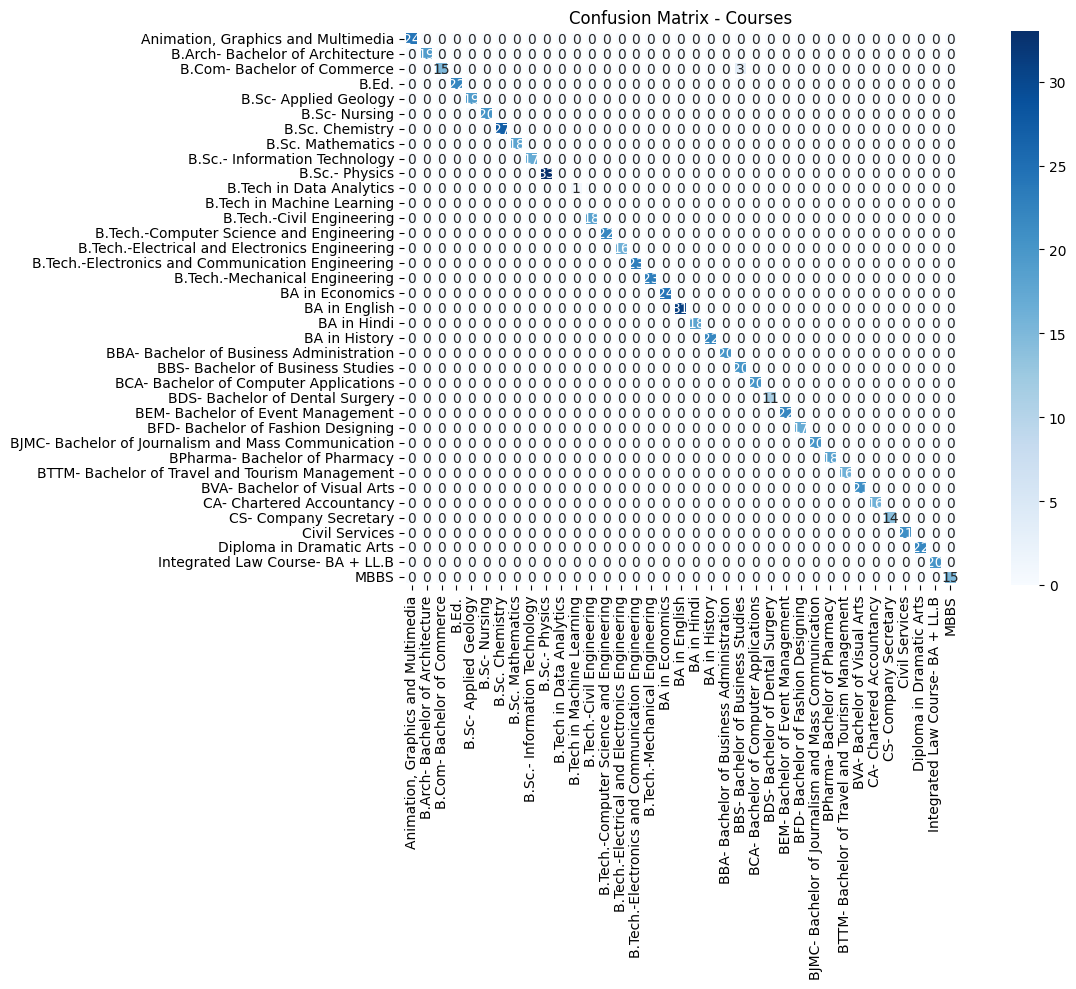

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

# Compute confusion matrix
cm = confusion_matrix(y_course_test, y_course_pred)
labels_in_test = unique_labels(y_course_test, y_course_pred)
class_names = course_encoder.inverse_transform(labels_in_test)

# Plot with spacing between cells
plt.figure(figsize=(14, 10))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=class_names,
    yticklabels=class_names,
    square=True,
    linewidths=1.5,  # Adds space between cells
    linecolor='white'
)

plt.title("Confusion Matrix - Courses")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

### **Observations**

- **Strong Predictive Accuracy**:  
  Courses like **MBBS**, **B.Tech-Computer Science and Engineering**, and **B.Com** show dominant diagonal values with minimal scatter—this means the model identifies these courses reliably.

- **Common Confusions**:  
  Several overlapping predictions occur among similar domains:
  - **B.Tech in Data Analytics** is confused with other tech-heavy programs like **B.Tech in Machine Learning** or **BCA**.
  - **BA in English**, **BA in Hindi**, and **BA in History** have cross-predictions, suggesting linguistic/humanities-oriented profiles are hard to distinguish.
  - **B.Sc. specializations** such as Chemistry, Physics, and IT sometimes blur, indicating possible feature overlap in input data.

- **Sparse Rows/Columns**:  
  Labels such as **Diploma in Dramatic Arts**, **CA**, **CS**, and **BEM** have very few data points, implying:
  - Either they are underrepresented in the training/test set.
  - Or the model lacks distinguishing features for these niche categories.

---



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


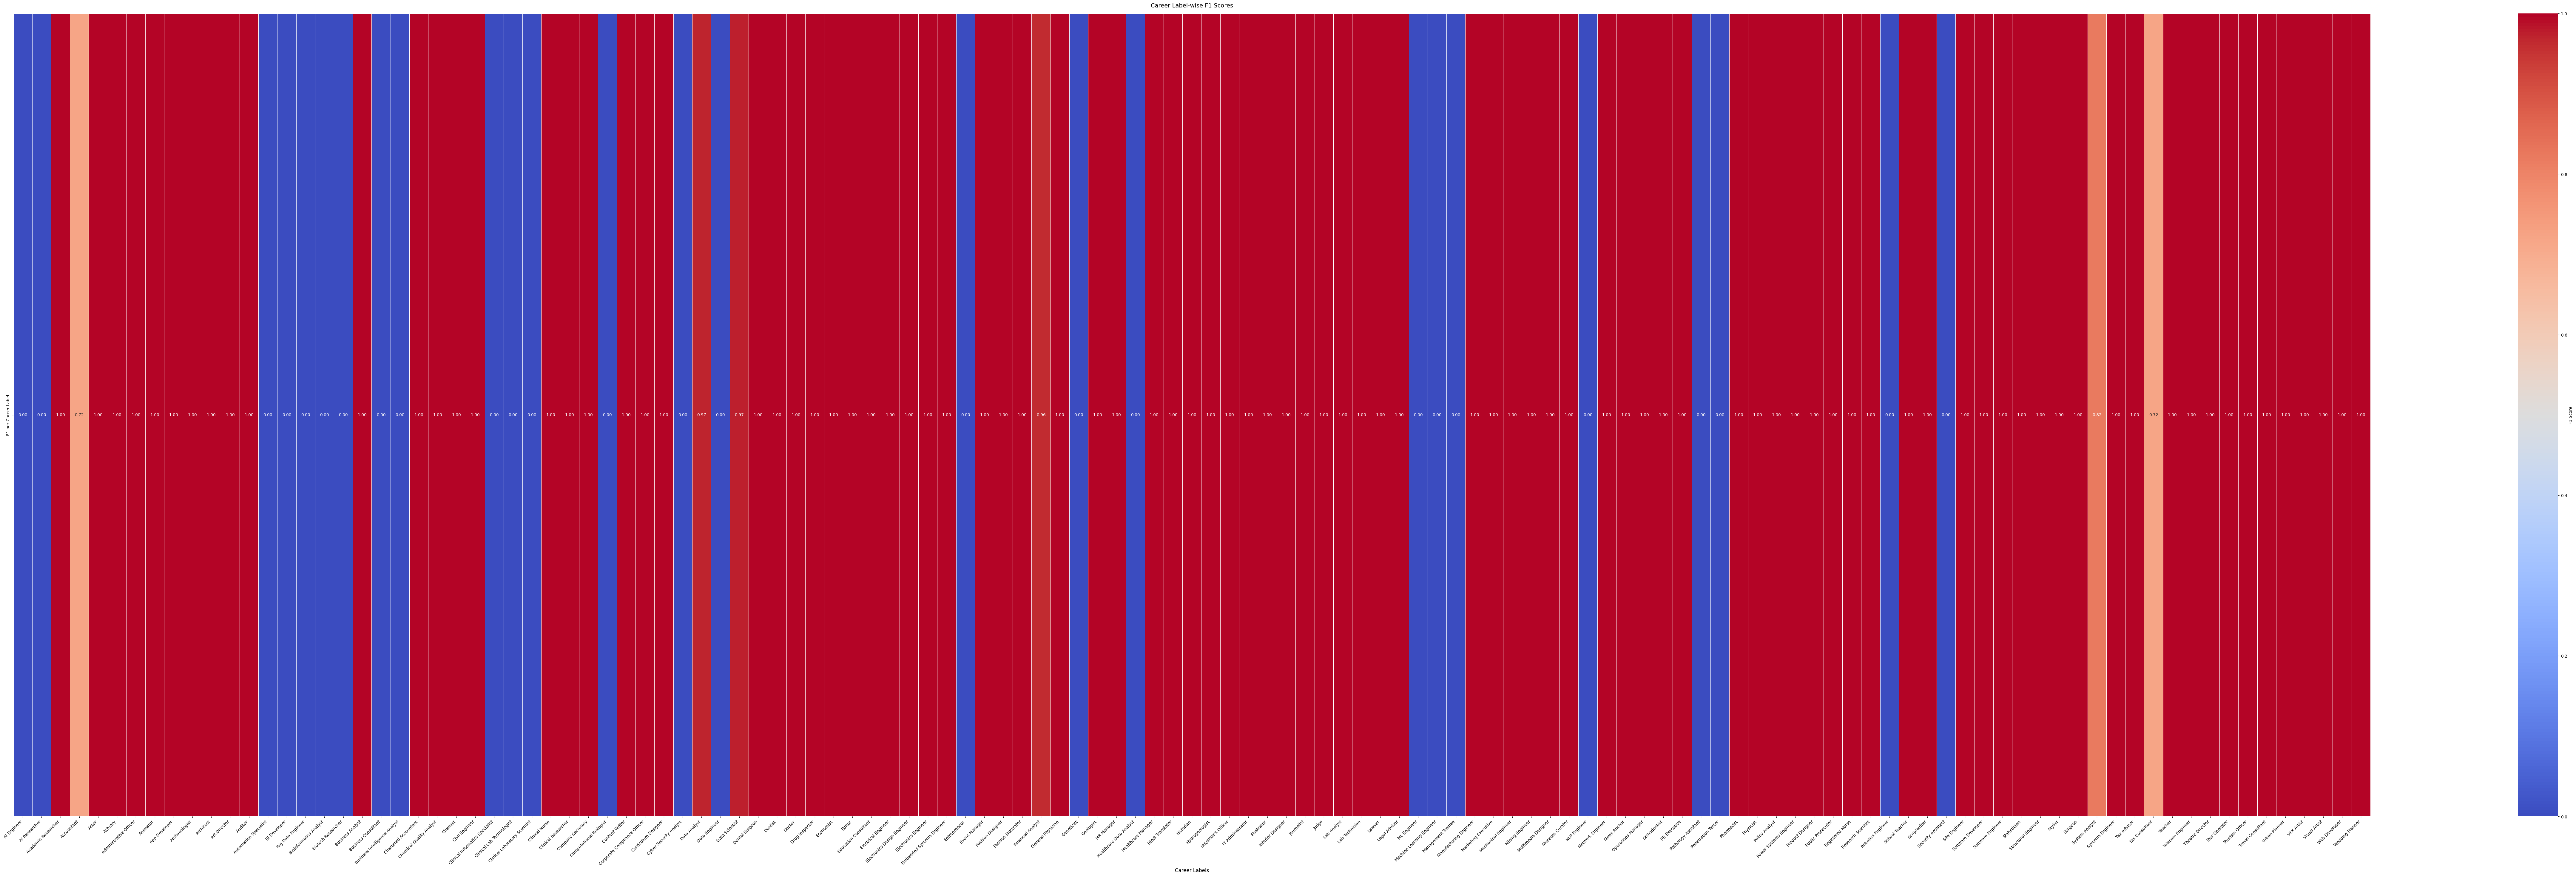

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score
import numpy as np

# Compute F1 scores
f1_scores = f1_score(y_career_test, y_career_pred_binary, average=None).reshape(1, -1)

# Set up the plot
plt.figure(figsize=(max(14, len(career_mlb.classes_) * 0.8), 30))  # Scale width to number of labels

sns.heatmap(
    f1_scores,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    cbar_kws={"orientation": "vertical", "label": "F1 Score"},
    yticklabels=["F1 per Career Label"],
    xticklabels=career_mlb.classes_,
    linewidths=0.5,
    linecolor='white'
)

# Rotate and space out x-axis labels
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.title("Career Label-wise F1 Scores", fontsize=14, pad=15)
plt.xlabel("Career Labels", fontsize=12)
plt.ylabel("")
plt.tight_layout(pad=3)
plt.show()


### **Observations**

- **Performance Variance**:  
  There's a noticeable range in F1 scores—some careers exhibit strong predictive alignment (scores closer to red zones), while others show moderate or weak alignment (blues), indicating class-specific modeling strengths and weaknesses.

- **Top Performers**:  
  Careers with **high F1 scores** are likely to have:
  - Distinctive patterns in the input data (e.g., clear interest or aptitude signals).
  - Strong representation in the training dataset.

- **Underperformers**:  
  Careers with **low F1 scores** may suffer from:
  - Feature overlap with other classes (e.g., similar academic profiles).
  - Low sample size or class imbalance.

- **Label Density Considerations**:  
  Dense or overlapping x-axis labels suggest a large number of career categories—future enhancements might include sorting by F1 score or grouping by domain for clarity.

---



In [40]:
import numpy as np

# Print all 59 features
print("Select your interests/skills from the list below (input numbers like 5, 9, 25):\n")
for i, feature in enumerate(X.columns, 1):
    print(f"{i:2d}. {feature}")

Select your interests/skills from the list below (input numbers like 5, 9, 25):

 1. Drawing
 2. Dancing
 3. Singing
 4. Sports
 5. Video_Game
 6. Acting
 7. Travelling
 8. Gardening
 9. Animals
10. Photography
11. Teaching
12. Exercise
13. Coding
14. Electricity_Components
15. Mechanic_Parts
16. Computer_Parts
17. Researching
18. Architecture
19. Historic_Collection
20. Botany
21. Zoology
22. Physics
23. Accounting
24. Economics
25. Sociology
26. Geography
27. Psycology
28. History
29. Science
30. Bussiness_Education
31. Chemistry
32. Mathematics
33. Biology
34. Makeup
35. Designing
36. Content_Writing
37. Crafting
38. Literature
39. Reading
40. Cartooning
41. Debating
42. Asrtology
43. Hindi
44. French
45. English
46. Urdu
47. Other Language
48. Solving_Puzzles
49. Gymnastics
50. Yoga
51. Engeeniering
52. Doctor
53. Pharmisist
54. Cycling
55. Knitting
56. Director
57. Journalism
58. Bussiness
59. Listening_Music


In [70]:
# Get user input
user_input = input("\nEnter the numbers of your interests/skills (comma-separated): ")
selected_indices = [int(i.strip()) - 1 for i in user_input.split(",") if i.strip().isdigit() and 0 < int(i) <= 59]



Enter the numbers of your interests/skills (comma-separated): 13,14,15,16,17,48


In [71]:
# Create binary vector
input_vector = [1 if i in selected_indices else 0 for i in range(59)]


In [72]:
# Predict Course
course_pred_encoded = rf_model.predict([input_vector])
course_name = course_encoder.inverse_transform(course_pred_encoded)[0]


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [73]:
# Predict Career Options
career_pred_raw = career_nn_model.predict(np.array([input_vector]))
career_binary = (career_pred_raw > 0.3).astype(int)

# Fallback: if no predictions above threshold, pick top 3
if not career_binary.any():
    top_n = 3
    top_indices = career_pred_raw[0].argsort()[-top_n:][::-1]
    career_binary[0, top_indices] = 1

career_options = career_mlb.inverse_transform(career_binary)[0]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


In [74]:
# Output results
print("\n Recommended Course:", course_name)
print(" Suggested Career Options:", ', '.join(career_options) if career_options else "None")



 Recommended Course: BCA- Bachelor of Computer Applications
 Suggested Career Options: App Developer, Electronics Engineer, Embedded Systems Engineer, Software Engineer, Systems Engineer, Telecom Engineer
